In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima


In [2]:
load_path = 'processed_data/data_2006_2023.csv'

In [3]:
load_data = pd.read_csv(load_path)

In [4]:
load_data

,loadConsumption,date,datetime,Hour,Year
0,10215.0000,2006-01-01,2005-12-31 23:00:00,0,2006
1,9979.0000,2006-01-01,2006-01-01 00:00:00,1,2006
2,9460.0000,2006-01-01,2006-01-01 01:00:00,2,2006
3,8833.0000,2006-01-01,2006-01-01 02:00:00,3,2006
4,8525.0000,2006-01-01,2006-01-01 03:00:00,4,2006
...,...,...,...,...,...
157767,12673.4650,2023-12-31,2023-12-31 19:00:00,20,2023
157768,12366.1950,2023-12-31,2023-12-31 20:00:00,21,2023
157769,12143.1775,2023-12-31,2023-12-31 21:00:00,22,2023
157770,11993.1200,2023-12-31,2023-12-31 22:00:00,23,2023


In [5]:
# Check for stationarity using Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("Data is stationary")
    else:
        print("Data is NOT stationary")

In [6]:
adf_test(load_data["loadConsumption"])


ADF Statistic: -27.204566436886566
p-value: 0.0
Data is stationary


In [7]:
# Load data (ensure the date column is in datetime format)
df = load_data.copy()  
df["date"] = pd.to_datetime(df["date"])

In [8]:
# Aggregate hourly data to daily
df_daily = df.groupby("date")["loadConsumption"].sum().reset_index()

adf_test(df_daily["loadConsumption"])


ADF Statistic: -5.328020413730685
p-value: 4.789379447396945e-06
Data is stationary


### ARIMA 
On daily load consumption

In [9]:
# Split into train-test sets (e.g., last 365 days for testing)
train_size = len(df_daily) - 365
train, test = df_daily[:train_size], df_daily[train_size:]

# Use Auto-ARIMA to find the best (p, d, q) parameters
auto_model = auto_arima(train["loadConsumption"], seasonal=False, stepwise=True, suppress_warnings=True)
print(f"Optimal ARIMA parameters: {auto_model.order}")

# Train ARIMA model using the best parameters
p, d, q = auto_model.order
model = ARIMA(train["loadConsumption"], order=(p, d, q))
model_fit = model.fit()

# Make predictions
forecast = model_fit.forecast(steps=len(test))

Optimal ARIMA parameters: (2, 1, 2)


C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [10]:
from sklearn.metrics import r2_score, mean_absolute_error

# Calculate R^2 score
r2 = r2_score(test["loadConsumption"], forecast)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((test["loadConsumption"] - forecast) / test["loadConsumption"])) * 100

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test["loadConsumption"], forecast)

# Calculate RMSE
rmse = np.sqrt(np.mean((forecast - test["loadConsumption"])**2))


# Print additional metrics
print(f"R^2 Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse}")


R^2 Score: -0.4579
MAPE: 8.72%
MAE: 27290.9059
RMSE: 34386.95768458603


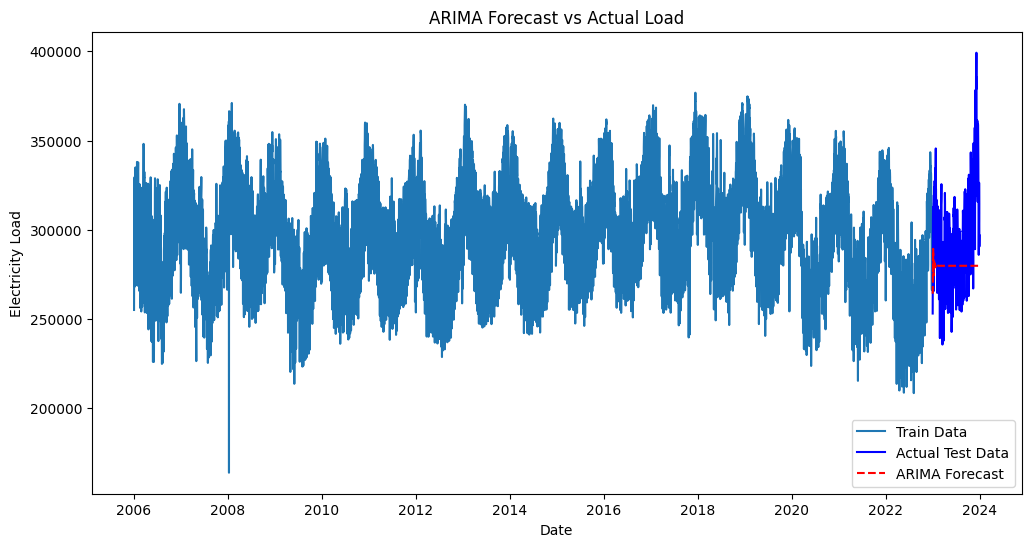

In [11]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train["date"], train["loadConsumption"], label="Train Data")
plt.plot(test["date"], test["loadConsumption"], label="Actual Test Data", color="blue")
plt.plot(test["date"], forecast, label="ARIMA Forecast", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Electricity Load")
plt.title("ARIMA Forecast vs Actual Load")
plt.legend()
plt.show()


The model is not capturing any pattern

### weather data

In [12]:
weather_data_path = 'processed_data/weather.csv' 
weather_data = pd.read_csv(weather_data_path)

In [13]:
weather_data.head()

,Date,DailyPrecipitation,MaxHourlyPrecipitation,HDMaxPrecipitation,DailyMeanTemperature,HourlyMinTemperature,HDMinTemperature,HourlyMaxTemperature,HDMaxTemperature,DailyMeanWindspeed,MaxHourlyMeanWindspeed,HDMaxMeanWindspeed,MinHourlyMeanWindspeed,HDMinMeanWindspeed,Month,Year,Week,WeekKey,day_of_week
0,2006-01-01,0.0,0.0,1,4.0,23,7,5.3,13,2.4,4.0,1,1.0,15,1,2006,52,200652,Sunday
1,2006-01-02,-0.1,-0.1,10,1.5,-35,24,5.6,14,1.3,3.0,14,0.0,4,1,2006,1,200601,Monday
2,2006-01-03,-0.1,-0.1,20,-0.2,-45,8,4.5,12,1.6,3.0,19,1.0,1,1,2006,1,200601,Tuesday
3,2006-01-04,-0.1,-0.1,1,1.6,-5,24,3.8,13,2.9,5.0,21,1.0,3,1,2006,1,200601,Wednesday
4,2006-01-05,0.0,0.0,1,0.7,-13,7,1.9,20,4.6,6.0,3,3.0,8,1,2006,1,200601,Thursday


In [14]:
weather_data["Date"] = pd.to_datetime(weather_data["Date"])

In [15]:
# Merge temperature data
df_merged = pd.merge(df_daily, weather_data, left_on='date', right_on='Date', how='inner')

df_merged.drop(columns=['Date'], inplace=True)

In [16]:
df_merged["is_weekend"] = df_merged["date"].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)


In [17]:
import holidays
# Define holidays for the Netherlands
nl_holidays = holidays.NL(years=df_merged["date"].dt.year.unique())

# Create a binary column for holidays (1 = holiday, 0 = non-holiday)
df_merged["is_holiday"] = df_merged["date"].apply(lambda x: 1 if x in nl_holidays else 0)


In [18]:
df_merged.head()

,date,loadConsumption,DailyPrecipitation,MaxHourlyPrecipitation,HDMaxPrecipitation,DailyMeanTemperature,HourlyMinTemperature,HDMinTemperature,HourlyMaxTemperature,HDMaxTemperature,...,HDMaxMeanWindspeed,MinHourlyMeanWindspeed,HDMinMeanWindspeed,Month,Year,Week,WeekKey,day_of_week,is_weekend,is_holiday
0,2006-01-01,255022.0,0.0,0.0,1,4.0,23,7,5.3,13,...,1,1.0,15,1,2006,52,200652,Sunday,1,1
1,2006-01-02,314663.0,-0.1,-0.1,10,1.5,-35,24,5.6,14,...,14,0.0,4,1,2006,1,200601,Monday,0,0
2,2006-01-03,326082.0,-0.1,-0.1,20,-0.2,-45,8,4.5,12,...,19,1.0,1,1,2006,1,200601,Tuesday,0,0
3,2006-01-04,328763.0,-0.1,-0.1,1,1.6,-5,24,3.8,13,...,21,1.0,3,1,2006,1,200601,Wednesday,0,0
4,2006-01-05,329469.0,0.0,0.0,1,0.7,-13,7,1.9,20,...,3,3.0,8,1,2006,1,200601,Thursday,0,0


In [19]:
#df_merged.to_csv('df_merged.csv', index = False)

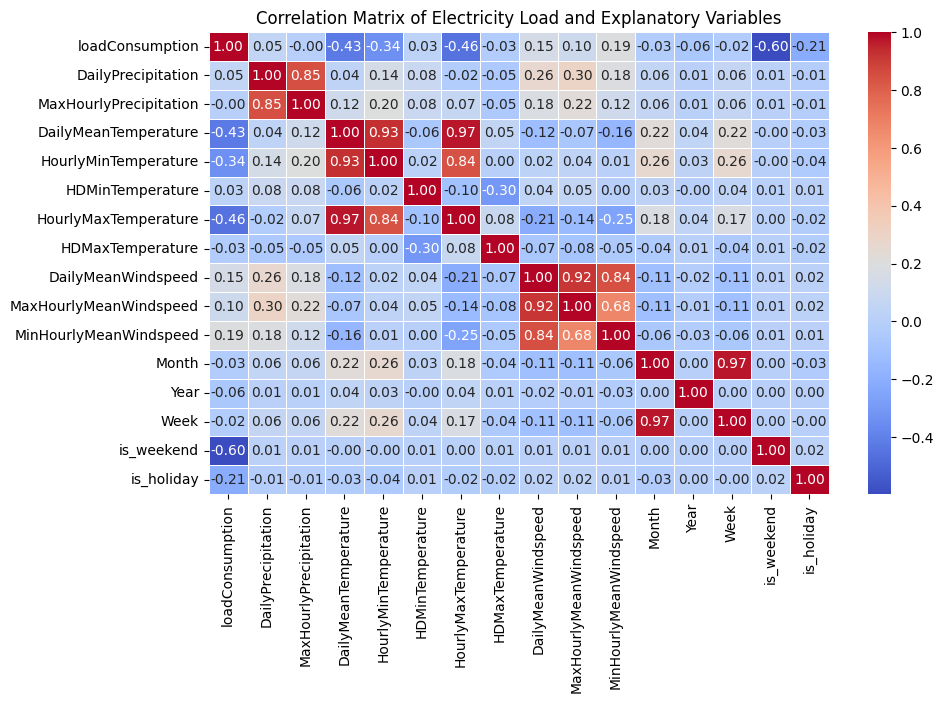

In [20]:
import seaborn as sns

# Drop redundant columns
df_cleaned = df_merged.drop(columns=[ "WeekKey",
                                     "day_of_week", "HDMaxPrecipitation", 
                                     "HDMaxMeanWindspeed", "HDMinMeanWindspeed"])

# Convert date column to datetime format
df_cleaned["date"] = pd.to_datetime(df_cleaned["date"])

numeric_cols = df_cleaned.select_dtypes(include=["number"])

# Compute correlation matrix
corr_matrix = numeric_cols.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Electricity Load and Explanatory Variables")
plt.show()


In [21]:
df_merged.columns

Index(['date', 'loadConsumption', 'DailyPrecipitation',
       'MaxHourlyPrecipitation', 'HDMaxPrecipitation', 'DailyMeanTemperature',
       'HourlyMinTemperature', 'HDMinTemperature', 'HourlyMaxTemperature',
       'HDMaxTemperature', 'DailyMeanWindspeed', 'MaxHourlyMeanWindspeed',
       'HDMaxMeanWindspeed', 'MinHourlyMeanWindspeed', 'HDMinMeanWindspeed',
       'Month', 'Year', 'Week', 'WeekKey', 'day_of_week', 'is_weekend',
       'is_holiday'],
      dtype='object')

## SARIMAX (weather data, rolling averags, holiday feature)

In [22]:
# Convert 'date' to datetime format
df_merged["date"] = pd.to_datetime(df_merged["date"])

# Drop unnecessary columns
columns_to_drop = [
    "WeekKey","Year", "Month",'day_of_week',
    "MaxHourlyPrecipitation", "HourlyMaxTemperature", "HDMaxTemperature",  
    "HDMaxMeanWindspeed", "HDMinMeanWindspeed", "MinHourlyMeanWindspeed"  
]

df_sarimax = df_merged.drop(columns=columns_to_drop)

# Convert categorical columns to numeric
df_sarimax.set_index("date", inplace=True)

df_sarimax["day_of_week"] = df_sarimax.index.weekday
df_sarimax["is_weekend"] = df_sarimax["is_weekend"].astype(int)
df_sarimax["is_holiday"] = df_sarimax["is_holiday"].astype(int)
df_sarimax["rolling_7d"] = df_sarimax["loadConsumption"].rolling(7).mean()
df_sarimax["rolling_30d"] = df_sarimax["loadConsumption"].rolling(30).mean()
df_sarimax = df_sarimax.fillna(method='bfill')  # Fill missing values


# Display structure after cleaning
df_sarimax.info()
df_sarimax.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6574 entries, 2006-01-01 to 2023-12-31
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   loadConsumption         6574 non-null   float64
 1   DailyPrecipitation      6574 non-null   float64
 2   HDMaxPrecipitation      6574 non-null   int64  
 3   DailyMeanTemperature    6574 non-null   float64
 4   HourlyMinTemperature    6574 non-null   int64  
 5   HDMinTemperature        6574 non-null   int64  
 6   DailyMeanWindspeed      6574 non-null   float64
 7   MaxHourlyMeanWindspeed  6574 non-null   float64
 8   Week                    6574 non-null   int64  
 9   is_weekend              6574 non-null   int32  
 10  is_holiday              6574 non-null   int32  
 11  day_of_week             6574 non-null   int32  
 12  rolling_7d              6574 non-null   float64
 13  rolling_30d             6574 non-null   float64
dtypes: float64(7), int32(3

C:\Users\mahmo\AppData\Local\Temp\ipykernel_5964\3651429030.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sarimax = df_sarimax.fillna(method='bfill')  # Fill missing values


,loadConsumption,DailyPrecipitation,HDMaxPrecipitation,DailyMeanTemperature,HourlyMinTemperature,HDMinTemperature,DailyMeanWindspeed,MaxHourlyMeanWindspeed,Week,is_weekend,is_holiday,day_of_week,rolling_7d,rolling_30d
date,,,,,,,,,,,,,,
2006-01-01,255022.0,0.0,1,4.0,23,7,2.4,4.0,52,1,1,6,309559.285714,313095.533333
2006-01-02,314663.0,-0.1,10,1.5,-35,24,1.3,3.0,1,0,0,0,309559.285714,313095.533333
2006-01-03,326082.0,-0.1,20,-0.2,-45,8,1.6,3.0,1,0,0,1,309559.285714,313095.533333
2006-01-04,328763.0,-0.1,1,1.6,-5,24,2.9,5.0,1,0,0,2,309559.285714,313095.533333
2006-01-05,329469.0,0.0,1,0.7,-13,7,4.6,6.0,1,0,0,3,309559.285714,313095.533333


 auto_arima helps in selecting the optimal ARIMA model by searching through different combinations of parameters and choosing the best one based on a metric like AIC (Akaike Information Criterion).

In [23]:
from pmdarima import auto_arima

# Run Auto-ARIMA to find optimal parameters
auto_model = auto_arima(df_sarimax["loadConsumption"], seasonal=True, m=7, 
                        exogenous=df_sarimax[["day_of_week", "rolling_7d", "rolling_30d", "is_weekend", "is_holiday"]], 
                        stepwise=True, trace=True)

auto_model.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=13.44 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=151489.707, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=147076.840, Time=1.24 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=148769.036, Time=1.26 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=151487.707, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=151491.707, Time=0.27 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=146721.318, Time=2.39 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=5.59 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=143023.506, Time=8.51 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=148829.129, Time=0.83 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=144073.127, Time=13.29 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=148011.527, Time=1.70 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=14.44 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=5.47 sec
 ARIMA(2,1,0)(1,0,1)[7] interc

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 6574
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood              -71496.257
Date:                           Wed, 26 Feb 2025   AIC                         143004.513
Time:                                   17:08:07   BIC                         143045.258
Sample:                               01-01-2006   HQIC                        143018.598
                                    - 12-31-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    513.6809     61.018      8.419      0.000     394.089     633.273
ar.L1          0.3713      0.035     10.598      0.000       0.303       0.440
ma.L1         -0.6511      0.035    -18.857      0.000      -0.719      -0.583
ar.S.L7        0.9679      0.003    384.898      0.000       0.963       0.973
ma.S.L7       -0.5350      0.010    -51.272      0.000      -0.555      -0.515
sigma2      2.474e+08      0.001   4.83e+11      0.000    2.47e+08    2.47e+08
===================================================================================
Ljung-Box (L1) (Q):                   9.84   Jarque-Bera (JB):            411306.32
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                            -1.92
Prob(H) (two-sided):                  0.00   Kurtosis:                        41.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.51e+25. Standard errors may be unstable.
"""

In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [25]:
# Train-test split
train_size = int(len(df_sarimax) * 0.8)
train, test = df_sarimax.iloc[:train_size], df_sarimax.iloc[train_size:]

In [26]:
# Define endogenous (target) and exogenous (features)
endog_train = train["loadConsumption"]
exog_train = train[["day_of_week", "rolling_7d", "rolling_30d", "is_weekend", "is_holiday"]]

endog_test = test["loadConsumption"]
exog_test = test[["day_of_week", "rolling_7d", "rolling_30d", "is_weekend", "is_holiday"]]

In [28]:
# Use Auto-ARIMA parameters if available
best_p, best_d, best_q = auto_model.order  
best_P, best_D, best_Q, best_s = auto_model.seasonal_order

In [29]:
# Train SARIMAX model
sarimax_model = SARIMAX(endog_train, exog=exog_train, 
                        order=(best_p, best_d, best_q), 
                        seasonal_order=(best_P, best_D, best_Q, best_s),  
                        enforce_stationarity=False,
                        enforce_invertibility=False)

sarimax_fit = sarimax_model.fit()

# Forecast
forecast = sarimax_fit.forecast(steps=len(test), exog=exog_test)

# Prevent negative values
forecast = np.maximum(forecast, 0)


C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [32]:
#Model Evaluation _ no weather data

# RMSE
rmse_sarimax = np.sqrt(((forecast - endog_test) ** 2).mean())

# R^2 Score
r2_sarimax = r2_score(endog_test, forecast)

# Mean Absolute Percentage Error (MAPE)
mape_sarimax = np.mean(np.abs((endog_test - forecast) / endog_test)) * 100

# Mean Absolute Error (MAE)
mae_sarimax = mean_absolute_error(endog_test, forecast)

print(f" RMSE: {rmse_sarimax}")
print(f" R2: {r2_sarimax}")
print(f" MAPE: {mape_sarimax}")
print(f" MAE: {mae_sarimax}")

# Save metrics to a DataFrame
metrics_sarimax_df = pd.DataFrame({
    "Metric": ["RMSE", "R^2 Score", "MAPE", "MAE"],
    "Value": [rmse_sarimax, r2_sarimax, mape_sarimax, mae_sarimax]
})



 RMSE: 9785.295628549196
 R2: 0.9035505433312264
 MAPE: 2.680027586188591
 MAE: 7602.014275314446


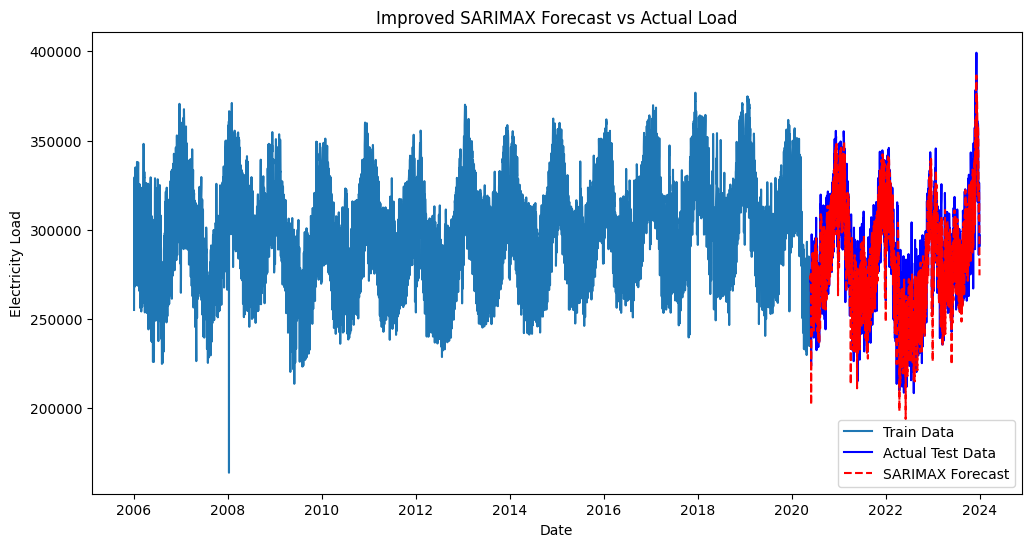

In [33]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train["loadConsumption"], label="Train Data")
plt.plot(test.index, test["loadConsumption"], label="Actual Test Data", color="blue")
plt.plot(test.index, forecast, label="SARIMAX Forecast", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Electricity Load")
plt.title("Improved SARIMAX Forecast vs Actual Load")
plt.legend()
plt.show()

In [34]:
# Save to a CSV file
file_path_sarimax = "metrics/sarimax_metrics.csv"
metrics_sarimax_df.to_csv(file_path_sarimax, index=False)

In [35]:
# Convert categorical columns to numeric
df_merged.set_index("date", inplace=True)

df_merged["day_of_week"] = df_merged.index.weekday
df_merged["is_weekend"] = df_merged["is_weekend"].astype(int)
df_merged["is_holiday"] = df_merged["is_holiday"].astype(int)
df_merged["rolling_7d"] = df_merged["loadConsumption"].rolling(7).mean()
df_merged["rolling_30d"] = df_merged["loadConsumption"].rolling(30).mean()
df_sarimax = df_sarimax.fillna(method='bfill')  # Fill missing values


auto_model_2 = auto_arima(df_merged["loadConsumption"], seasonal=True, m=7, 
                        exogenous=df_merged[["DailyPrecipitation", "DailyMeanTemperature",
                                             "HourlyMinTemperature", "day_of_week",
                                             "rolling_7d", "rolling_30d"]],
                        stepwise=True, trace=True)
#print(auto_model_2.summary())

C:\Users\mahmo\AppData\Local\Temp\ipykernel_5964\3587982617.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sarimax = df_sarimax.fillna(method='bfill')  # Fill missing values


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=13.43 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=151489.707, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=147076.840, Time=1.19 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=148769.036, Time=1.21 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=151487.707, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=151491.707, Time=0.27 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=146721.318, Time=2.42 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=5.52 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=143023.506, Time=8.66 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=148829.129, Time=0.84 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=144073.127, Time=13.76 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=148011.527, Time=1.76 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=14.25 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=5.24 sec
 ARIMA(2,1,0)(1,0,1)[7] interc

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define endogenous (target) and exogenous (features)
endog_train = train["loadConsumption"]
exog_train = train[["DailyPrecipitation", "DailyMeanTemperature", "HourlyMinTemperature", 
                    "day_of_week", "rolling_7d", "rolling_30d"]]

endog_test = test["loadConsumption"]
exog_test = test[["DailyPrecipitation", "DailyMeanTemperature", "HourlyMinTemperature", 
                "day_of_week", "rolling_7d", "rolling_30d"]]

# Use Auto-ARIMA parameters if available
best_p, best_d, best_q = auto_model.order  
best_P, best_D, best_Q, best_s = auto_model.seasonal_order  

# Train SARIMAX model
sarimax_model = SARIMAX(endog_train, exog=exog_train, 
                        order=(best_p, best_d, best_q), 
                        seasonal_order=(best_P, best_D, best_Q, best_s),  
                        enforce_stationarity=False,
                        enforce_invertibility=False)

sarimax_fit = sarimax_model.fit()

# Forecast
forecast = sarimax_fit.forecast(steps=len(test), exog=exog_test)

# Prevent negative values
forecast = np.maximum(forecast, 0)

C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [37]:
# Evaluate performance
rmse_sarimax2 = np.sqrt(((forecast - endog_test) ** 2).mean())
r2_sarimax2 = r2_score(endog_test, forecast)
mape_sarimax2 = np.mean(np.abs((endog_test - forecast) / endog_test)) * 100
mae_sarimax2 = mean_absolute_error(endog_test, forecast)

print(f"RMSE: {rmse_sarimax2}")
print(f"R^2 Score: {r2_sarimax2:.4f}")
print(f"MAPE: {mape_sarimax2:.2f}%")
print(f"MAE: {mae_sarimax2:.4f}")

# Save metrics to a DataFrame
metrics_sarimax_df = pd.DataFrame({
    "Metric": ["RMSE", "R^2 Score", "MAPE", "MAE"],
    "Value": [rmse_sarimax2, r2_sarimax2, mape_sarimax2, mae_sarimax2]
})

# Save to a CSV file
file_path_sarimax = "metrics/sarimax_metrics(+weatherDate).csv"
metrics_sarimax_df.to_csv(file_path_sarimax, index=False)

print(f"Metrics saved to: {file_path_sarimax}")


RMSE: 10566.275454058119
R^2 Score: 0.8875
MAPE: 2.86%
MAE: 8089.8798
Metrics saved to: metrics/sarimax_metrics(+weatherDate).csv


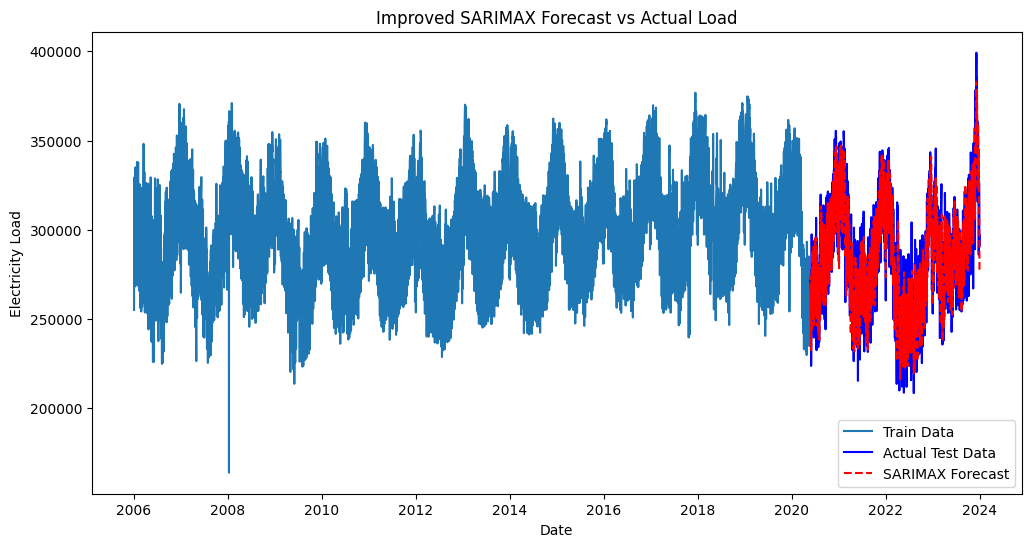

In [38]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train["loadConsumption"], label="Train Data")
plt.plot(test.index, test["loadConsumption"], label="Actual Test Data", color="blue")
plt.plot(test.index, forecast, label="SARIMAX Forecast", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Electricity Load")
plt.title("Improved SARIMAX Forecast vs Actual Load")
plt.legend()
plt.show()

#### 360 days of prediction

In [39]:
sarimax_fit = sarimax_model.fit()

# Forecast for x days
forecast_horizon = 365  # Change days
forecast = sarimax_fit.forecast(steps=forecast_horizon, exog=exog_test[:forecast_horizon])

# Prevent negative values
forecast = np.maximum(forecast, 0)


C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


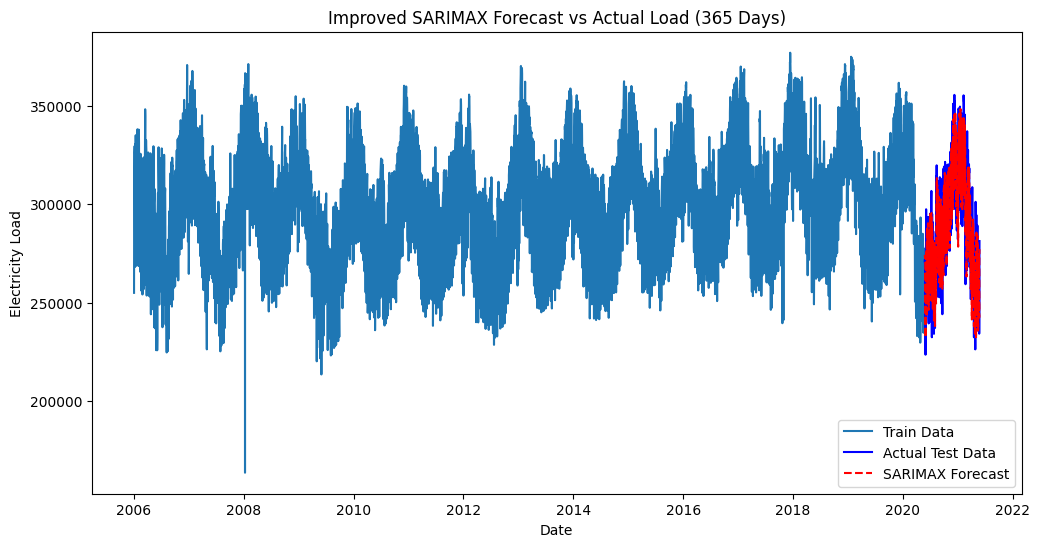

In [40]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train["loadConsumption"], label="Train Data")
plt.plot(test.index[:forecast_horizon], test["loadConsumption"].iloc[:forecast_horizon], label="Actual Test Data", color="blue")
plt.plot(test.index[:forecast_horizon], forecast, label="SARIMAX Forecast", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Electricity Load")
plt.title("Improved SARIMAX Forecast vs Actual Load ({} Days)".format(forecast_horizon))
plt.legend()
plt.show()

In [41]:
# Evaluate performance
rmse = np.sqrt(((forecast - endog_test.iloc[:forecast_horizon]) ** 2).mean())
r2_sarimax = r2_score(endog_test.iloc[:forecast_horizon], forecast)
mape_sarimax = np.mean(np.abs((endog_test.iloc[:forecast_horizon] - forecast) / endog_test.iloc[:forecast_horizon])) * 100
mae_sarimax = mean_absolute_error(endog_test.iloc[:forecast_horizon], forecast)

print(f"RMSE: {rmse}")
print(f"R^2 Score: {r2_sarimax:.4f}")
print(f"MAPE: {mape_sarimax:.2f}%")
print(f"MAE: {mae_sarimax:.4f}")

RMSE: 9826.673275287303
R^2 Score: 0.8933
MAPE: 2.60%
MAE: 7497.2219


In [42]:
# Save metrics to a DataFrame
metrics_sarimax_df = pd.DataFrame({
    "Metric": ["RMSE", "R^2 Score", "MAPE", "MAE"],
    "Value": [rmse, r2_sarimax, mape_sarimax, mae_sarimax]
})

# Save to a CSV file
file_path_sarimax = "metrics/sarimax_metrics(+weather,365).csv"
metrics_sarimax_df.to_csv(file_path_sarimax, index=False)